In [1]:
import csv
import sys
import os
import pickle
import random
import numpy as np
import time
import operator
import seaborn as sns
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt

from collections import Counter

import statsmodels.stats.api as sms

import scipy.stats
from scipy.stats import entropy
from scipy.stats import spearmanr
from scipy.stats import zscore
from sklearn.linear_model import LinearRegression
from sklearn.metrics.pairwise import cosine_similarity

In [2]:
sys.path.append('../python')
from permutation import permutation, compute_alignment_strength
from utils.utils_funcs import get_variance, get_distinctness, get_distinctness_from_nearest_5, aggregate_embeddings_visual_and_language
from utils.utils_funcs import load_data_to_dict

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
def dimension_reduction_TSNE(vectors,perplexity=30):
    from sklearn.manifold import TSNE
    tsne = TSNE(n_components=2, random_state=0, perplexity=perplexity)
    Y = tsne.fit_transform(vectors)
    mid = int(Y.shape[0]/2)
    # print(mid)
    return Y[:mid],Y[mid:]

# generate n distinct colors
def gen_distinct_colors(num_colors):
	import colorsys
	colors=[]
	for i in np.arange(0., 360., 360. / num_colors):
		hue = i/360.
		lightness = (50 + np.random.rand() * 10)/100.
		saturation = (90 + np.random.rand() * 10)/100.
		colors.append(colorsys.hls_to_rgb(hue, lightness, saturation))
	return np.array(colors)

def dup_list(lst,num):
    return [item for item in lst for _ in range(num)]

In [5]:
vg_noun_data=pickle.load(open("../data/dumped_embeddings/vg_noun_least20_ll_swav_bert_20.pkl","rb"))
vg_verb_data=pickle.load(open("../data/dumped_embeddings/vg_verb_least20_ll_swav_bert_20.pkl","rb"))

# aggregated_vg_noun_data=aggregate_embeddings_visual_and_language(vg_noun_data,1,1)
# aggregated_vg_verb_data=aggregate_embeddings_visual_and_language(vg_verb_data,1,1)

In [6]:
print(vg_noun_data['words'])

['man', 'window', 'woman', 'building', 'person', 'tree', 'wall', 'shirt', 'sky', 'water', 'grass', 'train', 'airplane', 'hand', 'car', 'cloud', 'pole', 'dog', 'girl', 'bus', 'road', 'giraffe', 'snow', 'elephant', 'head', 'street', 'cat', 'people', 'field', 'horse', 'light', 'leaf', 'boat', 'leg', 'clock', 'zebra', 'fence', 'hair', 'bird', 'pizza', 'floor', 'bicycle', 'hat', 'ear', 'bench', 'door', 'line', 'sidewalk', 'bear', 'wheel', 'shadow', 'rock', 'eye', 'flower', 'child', 'bed', 'beach', 'shoe', 'cow', 'trouser', 'chair', 'jacket', 'motorcycle', 'skateboard', 'truck', 'bowl', 'surfboard', 'sheep', 'numeral', 'bag', 'tail', 'desk', 'mirror', 'food', 'shelf', 'glass', 'umbrella', 'spectacles', 'foot', 'player', 'face', 'nose', 'wave', 'letter', 'handle', 'bottle', 'counter', 'arm', 'animal', 'sand', 'lady', 'box', 'picture', 'vase', 'pillow', 'sink', 'banana', 'guy', 'house', 'book', 'shrub', 'ocean', 'toilet', 'tile', 'sofa', 'tire', 'hill', 'jean', 'mountain', 'laptop', 'logo', 'c

In [11]:
vg_noun_concepts=['horse','dog','cow']

In [14]:
vg_verb_concepts=['stand','walk','sit']

In [15]:
def reformat_data_for_viz(data,concepts,num=20):
    vis_data=list()
    lang_data=list()
    for concept in concepts:
        for item in data['embeds'][concept]['visual'][:num]:
            vis_data.append(item)
        for item in data['embeds'][concept]['language'][:num]:
            lang_data.append(item)
    return np.array(vis_data),np.array(lang_data)

In [16]:
n_exemplar=20

In [17]:
vg_noun_vis,vg_noun_lang=reformat_data_for_viz(vg_noun_data,vg_noun_concepts,n_exemplar)
vg_verb_vis,vg_verb_lang=reformat_data_for_viz(vg_verb_data,vg_verb_concepts,n_exemplar)

In [18]:
vg_noun_vis.shape,vg_verb_vis.shape

((60, 128), (60, 128))

In [19]:
np.vstack([vg_noun_vis,vg_verb_vis]).shape

(120, 128)

In [20]:
vg_noun_vis_reduced,vg_verb_vis_reduced=dimension_reduction_TSNE(np.vstack([vg_noun_vis,vg_verb_vis]),perplexity=20)
vg_noun_lang_reduced,vg_verb_lang_reduced=dimension_reduction_TSNE(np.vstack([vg_noun_lang,vg_verb_lang]),perplexity=20)

In [21]:
vg_noun_vis.shape,vg_noun_vis_reduced.shape,vg_verb_vis.shape,vg_verb_vis_reduced.shape

((60, 128), (60, 2), (60, 128), (60, 2))

In [22]:
df_noun_vis=pd.DataFrame(vg_noun_vis_reduced,columns=['dim1','dim2'])
df_noun_vis['label']=dup_list(vg_noun_concepts,n_exemplar)
df_noun_lang=pd.DataFrame(vg_noun_lang_reduced,columns=['dim1','dim2'])
df_noun_lang['label']=dup_list(vg_noun_concepts,n_exemplar)
df_verb_vis=pd.DataFrame(vg_verb_vis_reduced,columns=['dim1','dim2'])
df_verb_vis['label']=dup_list(vg_verb_concepts,n_exemplar)
df_verb_lang=pd.DataFrame(vg_verb_lang_reduced,columns=['dim1','dim2'])
df_verb_lang['label']=dup_list(vg_verb_concepts,n_exemplar)

In [23]:
# compute centriods
def calculate_centroids(df,concepts):
    centroids=list()
    for concept in concepts:
        new_df=df.loc[df['label'] == concept]
        centroids.append((new_df['dim1'].mean(),new_df['dim2'].mean()))
    return np.array(centroids)

In [24]:
noun_vis_centroids=calculate_centroids(df_noun_vis,vg_noun_concepts)
noun_lang_centroids=calculate_centroids(df_noun_lang,vg_noun_concepts)
verb_vis_centroids=calculate_centroids(df_verb_vis,vg_verb_concepts)
verb_lang_centroids=calculate_centroids(df_verb_lang,vg_verb_concepts)

In [25]:
noun_vis_centroids.shape

(3, 2)

In [26]:
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

def plot_point_cov(points, nstd=2, ax=None, **kwargs):
    """
    Plots an `nstd` sigma ellipse based on the mean and covariance of a point
    "cloud" (points, an Nx2 array).

    Parameters
    ----------
        points : An Nx2 array of the data points.
        nstd : The radius of the ellipse in numbers of standard deviations.
            Defaults to 2 standard deviations.
        ax : The axis that the ellipse will be plotted on. Defaults to the 
            current axis.
        Additional keyword arguments are pass on to the ellipse patch.

    Returns
    -------
        A matplotlib ellipse artist
    """
    pos = points.mean(axis=0)
    cov = np.cov(points, rowvar=False)
    return plot_cov_ellipse(cov, pos, nstd, ax, **kwargs)

def plot_cov_ellipse(cov, pos, nstd=2, ax=None, **kwargs):
    """
    Plots an `nstd` sigma error ellipse based on the specified covariance
    matrix (`cov`). Additional keyword arguments are passed on to the 
    ellipse patch artist.

    Parameters
    ----------
        cov : The 2x2 covariance matrix to base the ellipse on
        pos : The location of the center of the ellipse. Expects a 2-element
            sequence of [x0, y0].
        nstd : The radius of the ellipse in numbers of standard deviations.
            Defaults to 2 standard deviations.
        ax : The axis that the ellipse will be plotted on. Defaults to the 
            current axis.
        Additional keyword arguments are pass on to the ellipse patch.

    Returns
    -------
        A matplotlib ellipse artist
    """
    def eigsorted(cov):
        vals, vecs = np.linalg.eigh(cov)
        order = vals.argsort()[::-1]
        return vals[order], vecs[:,order]

    if ax is None:
        ax = plt.gca()

    vals, vecs = eigsorted(cov)
    theta = np.degrees(np.arctan2(*vecs[:,0][::-1]))

    # Width and height are "full" widths, not radius
    width, height = 2 * nstd * np.sqrt(vals)
    ellip = Ellipse(xy=pos, width=width, height=height, angle=theta, **kwargs)

    ax.add_artist(ellip)
    return ellip

In [211]:
def draw_exemplars(data,categories,n_exemplar,colors,ax):
    for n, color in enumerate(colors):
        category_points=data[n*n_exemplar:(n+1)*n_exemplar]
        ax.scatter(
            category_points[:, 0], category_points[:, 1], s=5, color=color, label=categories[n]
        )
    # plt.legend(scatterpoints=1, prop=dict(size=12))

def draw_ellipses(data,n_exemplar,colors,ax):
    for n, color in enumerate(colors):
        plot_point_cov(data[n*n_exemplar:(n+1)*n_exemplar],nstd=1, alpha=0.5, color=color,ax=ax)

def draw_centriods(centroids,colors,ax):
    for n, color in enumerate(colors):
        ax.scatter(
            centroids[n,0],centroids[n,1],s=50,color=color
        )
        
def draw_pairwise_arrow(data,ax):
    from itertools import combinations
    import matplotlib.patches as patches
    for i,j in list(combinations(data, 2)):
        # print(i,j)
        arrow = patches.FancyArrowPatch(i, j, arrowstyle='<|-|>', mutation_scale=10, color='#CBCBCB',linewidth=3, shrinkA=5,shrinkB=5)
        ax.add_patch(arrow)
        
def draw_everything(data,centroids,categories,n_exemplar,colors,ax):
    draw_exemplars(data,categories,n_exemplar,colors,ax)
    draw_ellipses(data,n_exemplar,colors,ax)
    draw_centriods(centroids,colors,ax)
    draw_pairwise_arrow(centroids,ax)

In [213]:
def rotate(p, origin=(0, 0), degrees=0):
    angle = np.deg2rad(degrees)
    R = np.array([[np.cos(angle), -np.sin(angle)],
                  [np.sin(angle),  np.cos(angle)]])
    o = np.atleast_2d(origin)
    p = np.atleast_2d(p)
    return np.squeeze((R @ (p.T-o.T) + o.T).T)

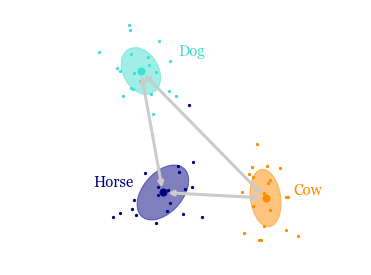

In [226]:
n_classes=3
cov_type='full'
colors = ["navy", "turquoise", "darkorange"]
fig, ax = plt.subplots(1, figsize=(6.4, 4.8))
ax.set_xlim(-18, 7)
ax.set_ylim(-12, 4)

draw_everything(
    data=vg_noun_lang_reduced,
    centroids=noun_lang_centroids,
    categories=vg_noun_concepts,
    n_exemplar=n_exemplar,
    colors=colors,
    ax=ax
)
ax.axis('off')

plt.text(-12,-7,'Horse',color='navy',fontname='Georgia',fontsize=15)
plt.text(-6,1,'Dog',color='turquoise',fontname='Georgia',fontsize=15)
plt.text(2,-7.5,'Cow',color='darkorange',fontname='Georgia',fontsize=15)

if save_fig:
    plt.savefig("../figs/viz_embed_noun_lang.png",dpi=600)
plt.show()

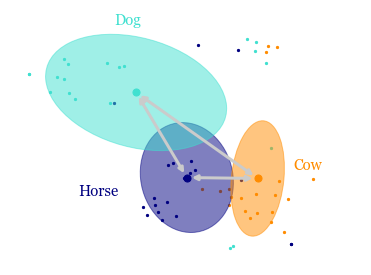

In [227]:
n_classes=3
cov_type='full'
colors = ["navy", "turquoise", "darkorange"]
# ax = plt.subplot()
fig, ax = plt.subplots(1, figsize=(6.4, 4.8))
ax.set_xlim(-15, 15)
ax.set_ylim(-20, 16)

draw_everything(
    data=rotate(vg_noun_vis_reduced,degrees=90),
    centroids=rotate(noun_vis_centroids,degrees=90),
    categories=vg_noun_concepts,
    n_exemplar=n_exemplar,
    colors=colors,
    ax=ax
)
# plt.xticks(())
# plt.yticks(())
ax.axis('off')

plt.text(-9,-10,'Horse',color='navy',fontname='Georgia',fontsize=15)
plt.text(-6,13.5,'Dog',color='turquoise',fontname='Georgia',fontsize=15)
plt.text(9,-6.5,'Cow',color='darkorange',fontname='Georgia',fontsize=15)

if save_fig:
    plt.savefig("../figs/viz_embed_noun_vis.png",dpi=600)
plt.show()

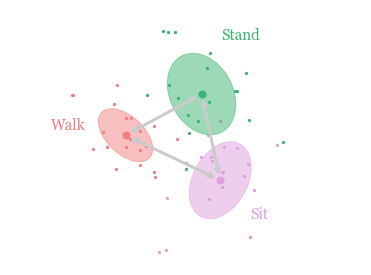

In [228]:
n_classes=3
cov_type='full'
colors = ["mediumseagreen", "lightcoral", "plum"]
fig, ax = plt.subplots(1, figsize=(6.4, 4.8))
ax.set_xlim(-5, 20)
ax.set_ylim(-3, 13)

draw_everything(
    data=vg_verb_lang_reduced,
    centroids=verb_lang_centroids,
    categories=vg_verb_concepts,
    n_exemplar=n_exemplar,
    colors=colors,
    ax=ax
)
ax.axis('off')

plt.text(10,11,'Stand',color='mediumseagreen',fontname='Georgia',fontsize=15)
plt.text(-2,5.5,'Walk',color='lightcoral',fontname='Georgia',fontsize=15)
plt.text(12,0,'Sit',color='plum',fontname='Georgia',fontsize=15)

if save_fig:
    plt.savefig("../figs/viz_embed_verb_lang.png",dpi=600)
plt.show()

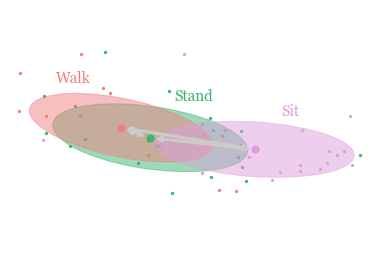

In [229]:
n_classes=3
cov_type='full'
colors = ["mediumseagreen", "lightcoral", "plum"]
fig, ax = plt.subplots(1, figsize=(6.4, 4.8))
ax.set_xlim(-15, 15)
ax.set_ylim(-20, 16)

draw_everything(
    data=rotate(vg_verb_vis_reduced,degrees=-50),
    centroids=rotate(verb_vis_centroids,degrees=-50),
    categories=vg_verb_concepts,
    n_exemplar=n_exemplar,
    colors=colors,
    ax=ax
)
ax.axis('off')

plt.text(-1,3,'Stand',color='mediumseagreen',fontname='Georgia',fontsize=15)
plt.text(-11,5.5,'Walk',color='lightcoral',fontname='Georgia',fontsize=15)
plt.text(8,1,'Sit',color='plum',fontname='Georgia',fontsize=15)

if save_fig:
    plt.savefig("../figs/viz_embed_verb_vis.png",dpi=600)
plt.show()

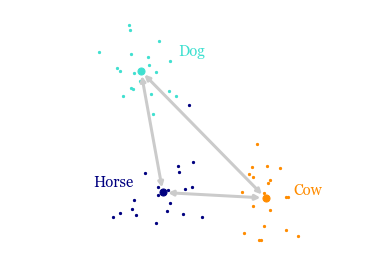

In [230]:
n_classes=3
cov_type='full'
colors = ["navy", "turquoise", "darkorange"]
fig, ax = plt.subplots(1, figsize=(6.4, 4.8))
ax.set_xlim(-18, 7)
ax.set_ylim(-12, 4)

draw_exemplars(vg_noun_lang_reduced,vg_noun_concepts,n_exemplar,colors,ax)
draw_centriods(noun_lang_centroids,colors,ax)
draw_pairwise_arrow(noun_lang_centroids,ax)

ax.axis('off')

plt.text(-12,-7,'Horse',color='navy',fontname='Georgia',fontsize=15)
plt.text(-6,1,'Dog',color='turquoise',fontname='Georgia',fontsize=15)
plt.text(2,-7.5,'Cow',color='darkorange',fontname='Georgia',fontsize=15)

if save_fig:
    plt.savefig("../figs/viz_embed_noun_lang_dist.png",dpi=600)
plt.show()

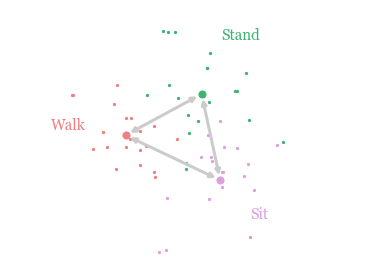

In [231]:
n_classes=3
cov_type='full'
colors = ["mediumseagreen", "lightcoral", "plum"]
fig, ax = plt.subplots(1, figsize=(6.4, 4.8))
ax.set_xlim(-5, 20)
ax.set_ylim(-3, 13)

draw_exemplars(vg_verb_lang_reduced,vg_verb_concepts,n_exemplar,colors,ax)
draw_centriods(verb_lang_centroids,colors,ax)
draw_pairwise_arrow(verb_lang_centroids,ax)

ax.axis('off')

plt.text(10,11,'Stand',color='mediumseagreen',fontname='Georgia',fontsize=15)
plt.text(-2,5.5,'Walk',color='lightcoral',fontname='Georgia',fontsize=15)
plt.text(12,0,'Sit',color='plum',fontname='Georgia',fontsize=15)

if save_fig:
    plt.savefig("../figs/viz_embed_verb_lang_dist.png",dpi=600)
plt.show()

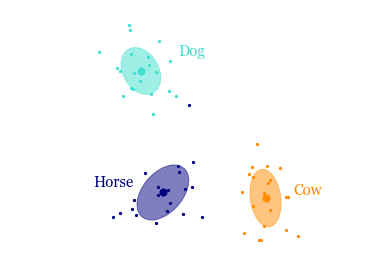

In [234]:
n_classes=3
cov_type='full'
colors = ["navy", "turquoise", "darkorange"]
fig, ax = plt.subplots(1, figsize=(6.4, 4.8))
ax.set_xlim(-18, 7)
ax.set_ylim(-12, 4)

draw_exemplars(vg_noun_lang_reduced,vg_noun_concepts,n_exemplar,colors,ax)
draw_centriods(noun_lang_centroids,colors,ax)
draw_ellipses(vg_noun_lang_reduced,n_exemplar,colors,ax)

ax.axis('off')

plt.text(-12,-7,'Horse',color='navy',fontname='Georgia',fontsize=15)
plt.text(-6,1,'Dog',color='turquoise',fontname='Georgia',fontsize=15)
plt.text(2,-7.5,'Cow',color='darkorange',fontname='Georgia',fontsize=15)

if save_fig:
    plt.savefig("../figs/viz_embed_noun_lang_var.png",dpi=600)
plt.show()

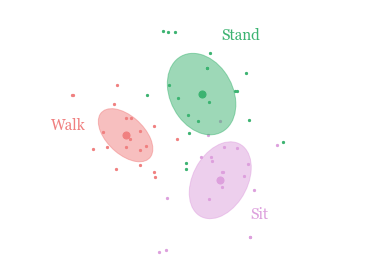

In [235]:
n_classes=3
cov_type='full'
colors = ["mediumseagreen", "lightcoral", "plum"]
fig, ax = plt.subplots(1, figsize=(6.4, 4.8))
ax.set_xlim(-5, 20)
ax.set_ylim(-3, 13)

draw_exemplars(vg_verb_lang_reduced,vg_verb_concepts,n_exemplar,colors,ax)
draw_centriods(verb_lang_centroids,colors,ax)
draw_ellipses(vg_verb_lang_reduced,n_exemplar,colors,ax)

ax.axis('off')

plt.text(10,11,'Stand',color='mediumseagreen',fontname='Georgia',fontsize=15)
plt.text(-2,5.5,'Walk',color='lightcoral',fontname='Georgia',fontsize=15)
plt.text(12,0,'Sit',color='plum',fontname='Georgia',fontsize=15)

if save_fig:
    plt.savefig("../figs/viz_embed_verb_lang_var.png",dpi=600)
plt.show()